# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a simple [linear regression model](https://scikit-learn.org/stable/modules/linear_model.html)
        - An advanced regressor of your choice (e.g., Random Forest, Neural Network, etc.)

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Assuming that the files `adult.data` and `adult.test` are in `../data/adult/`, then you can use the code below to load them.

In [3]:
import pandas as pd
import os
def find_data():
    """
    Function to find the file '../05_src/data/fires/forestfires.csv' using os.walk
    starting from the grandparents folder (two levels up from the current working directory).

    Returns:
    - str: The full file path if found, or None if not found.
    """
    target_file_path = None
    current_dir = os.getcwd()  # Get the current working directory

    # Navigate two levels up from the current directory
    grandparents_dir = os.path.abspath(os.path.join(current_dir, '../../'))

    # Walk through the directory tree starting from the grandparents directory
    for dirpath, dirnames, filenames in os.walk(grandparents_dir):
        # Check if '05_src/data/fires/forestfires.csv' exists in the current directory structure
        check_path = os.path.join(dirpath, '05_src/data/fires/forestfires.csv')
        if os.path.exists(check_path):
            target_file_path = check_path
            break
    
    return target_file_path

columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
# To avoid the column names being loaded as data
fires_dt = (pd.read_csv(find_data(), skiprows=1, names = columns))
fires_dt.describe()

,coord_x,coord_y,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


# Get X and Y

Create the features data frame and target data.

In [4]:
from sklearn.model_selection import train_test_split

X = fires_dt.drop(columns=['area'])  # Features (all columns except 'area')
y = fires_dt['area']  # Target variable ('area')

# To prepare for SHAP analysis on the test data, perform a train-test split for independent evaluation.
# However, due to the dataset's small size of only 517 rows and the fact that 'rain' is mostly 0,
# to avoid potential issues like 'Data must not be constant' in non-linear transformations,
# maintain a test set size above 0.2:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [5]:
# Before building preprocessor, identify 
# a) numerical features, 
# b) binary categorical features,
# c) non binary categorical features,
# d) datetime features.

# ** Treat 'month' and 'day' as categorical variables here 
# to make model treat each month and day of the week as distinct categories 
# without imposing any temporal order or relationship.

numeric_features = []
categorical_features = []
datetime_features = []

for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        # Exclude binary columns
        unique_values = X[col].dropna().unique()
        if len(unique_values) > 2:  # More than 2 unique values (not binary)
            numeric_features.append(col)
        else:  # Binary columns
            categorical_features.append(col)
    elif X[col].dtype == 'object' or X[col].dtype.name == 'category':
        categorical_features.append(col)
    elif X[col].dtype == 'datetime64[ns]':
        datetime_features.append(col)

# 2. Define non binary categorical columns and binary categorical columns
# Get non binary categorical features only for one hot encoding
binary_categorical_features = []
non_binary_categorical_features = []
for col in categorical_features:
    unique_values = X[col].dropna().unique()
    if set(unique_values) <= {0, 1}:
        binary_categorical_features.append(col)
    else:
        non_binary_categorical_features.append(col)

print(f"numeric_features are: {numeric_features}")
print(f"categorical_features are: {categorical_features}")
print(f"binary_categorical_features are: {binary_categorical_features}")
print(f"non_binary_categorical_features are: {non_binary_categorical_features}")

numeric_features are: ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features are: ['month', 'day']
binary_categorical_features are: []
non_binary_categorical_features are: ['month', 'day']


In [6]:
# preproc1

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder

# Most variables (including y) are skewed according to the pair plot,
# try testing RobustScaler for X variables in this case.
numeric_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

# Create preprocessor
preproc1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, non_binary_categorical_features)
    ],
    remainder='passthrough'
)
preproc1

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', RobustScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc2 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [7]:
# preproc2

from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import boxcox
import numpy as np

class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        # Box-Cox transformation does not require fitting based on y
        return self
    
    def transform(self, X):
        for feature in X.columns:
            X[feature], _ = boxcox(X[feature] + 1)
        return X
    
    def get_feature_names_out(self, input_features=None):
        return input_features  
    
scaled_features = ['ffmc', 'dmc', 'dc', 'isi']
nonlinear_features =[ 'rh', 'wind', 'rain']

nonlinear_transformer =  BoxCoxTransformer()
scaler = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

# Create preprocessor with non-linear transformation on numeric variables
preproc2 = ColumnTransformer(
    transformers=[
        ('num_nonlinear_transform', nonlinear_transformer, nonlinear_features),
        ('num_scaling', scaler, scaled_features),
        ('cat', categorical_transformer, non_binary_categorical_features)
    ],
    remainder='passthrough'
)
preproc2

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_nonlinear_transform', BoxCoxTransformer(),
                                 ['rh', 'wind', 'rain']),
                                ('num_scaling', RobustScaler(),
                                 ['ffmc', 'dmc', 'dc', 'isi']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [8]:
# Pipeline A = preproc1 + baseline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Define pipeline A: preproc1 + baseline regressor (RandomForestRegressor)
pipeline_A = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor())
])
pipeline_A

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

In [9]:
# Pipeline B = preproc2 + baseline
# Define pipeline B: preproc2 + baseline regressor (RandomForestRegressor)
pipeline_B = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor())
])
pipeline_B

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_nonlinear_transform',
                                                  BoxCoxTransformer(),
                                                  ['rh', 'wind', 'rain']),
                                                 ('num_scaling', RobustScaler(),
                                                  ['ffmc', 'dmc', 'dc', 'isi']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

In [10]:
# Pipeline C = preproc1 + advanced model
from sklearn.svm import SVR

# Define pipeline C: preproc1 + advanced regressor (SVR())
pipeline_C = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', SVR())
])
pipeline_C

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', SVR())])

In [11]:
# Pipeline D = preproc2 + advanced model
# Define pipeline D: preproc2 + advanced regressor (SVR())
pipeline_D = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', SVR())
])
pipeline_D

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_nonlinear_transform',
                                                  BoxCoxTransformer(),
                                                  ['rh', 'wind', 'rain']),
                                                 ('num_scaling', RobustScaler(),
                                                  ['ffmc', 'dmc', 'dc', 'isi']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', SVR())])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [12]:
# 0. Define a function to tune hyperparams for all the four pipelines
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def tune_hyperparams(X_train, y_train, param_grid, pipeline, cv =5, refit = 'neg_mean_squared_error', y_transformed = True):

    #1 Define the scoring metrics for regression
    scoring = [
        'neg_mean_squared_error', 
        'neg_mean_absolute_error', 
        'explained_variance', 
        'r2'
    ]

    #2 Perform GridSearch
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=5, 
        scoring=scoring,
        refit=refit,  # Refit based on neg_mean_squared_error for best model selection
        error_score= "raise"
    )
    if y_transformed:
        # The target variable y predominantly consists of zeros, with a maximum value of 1090.
        # The distribution exhibits significant skewness. 
        # Therefore, try employing Box-Cox transformation for smoothing.
        y_train, _ = boxcox(y_train + 1)

    grid_search.fit(X_train, y_train)

    #3 Display the results
    y_pred_train = grid_search.predict(X_train)
    absolute_errors = np.abs(y_train - y_pred_train)
    mad = np.mean(absolute_errors)
    print(f"MAD is {mad}")

    res = grid_search.cv_results_
    return pd.DataFrame(res), grid_search

In [13]:
# 1. Tune hyperparams for Pipeline_A - Random Forest
param_grid_A = {
    'regressor__n_estimators': [50, 100, 150],  # Number of trees in the forest
    'regressor__max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'regressor__min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'regressor__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'regressor__bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
}
res, grid_search_A = tune_hyperparams(X_train, y_train, param_grid_A, pipeline_A)
res_A = res[['mean_fit_time', 'mean_score_time', 
        'param_regressor__bootstrap', 'param_regressor__max_depth',
        'param_regressor__min_samples_leaf',
        'param_regressor__min_samples_split', 'param_regressor__n_estimators',
        'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
        'rank_test_neg_mean_squared_error',
        'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
        'rank_test_neg_mean_absolute_error', 
        'mean_test_explained_variance', 'std_test_explained_variance',
        'rank_test_explained_variance', 'mean_test_r2',
        'std_test_r2', 'rank_test_r2']].sort_values('rank_test_neg_mean_squared_error')
res_A

MAD is 0.3744973313119941


,mean_fit_time,mean_score_time,param_regressor__bootstrap,param_regressor__max_depth,param_regressor__min_samples_leaf,param_regressor__min_samples_split,param_regressor__n_estimators,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_test_explained_variance,std_test_explained_variance,rank_test_explained_variance,mean_test_r2,std_test_r2,rank_test_r2
18,0.137718,0.009707,True,NaN,4,2,50,-0.444247,0.066725,1,-0.594139,0.053794,1,-0.042281,0.085803,1,-0.047831,0.081568,1
22,0.265701,0.012604,True,NaN,4,5,100,-0.445942,0.069157,2,-0.597665,0.057413,16,-0.045476,0.079030,4,-0.050323,0.076698,3
106,0.259574,0.012357,True,30.0,4,10,100,-0.446110,0.070392,3,-0.597056,0.057439,9,-0.044980,0.074369,2,-0.050036,0.072076,2
107,0.382785,0.015379,True,30.0,4,10,150,-0.446520,0.074370,4,-0.597910,0.062176,18,-0.045528,0.086579,5,-0.050323,0.084750,4
100,0.266022,0.012589,True,30.0,4,2,100,-0.446570,0.072703,5,-0.596896,0.059416,7,-0.045086,0.087224,3,-0.051024,0.084173,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.540477,0.015400,False,20.0,2,2,150,-0.790475,0.077584,212,-0.686227,0.051716,210,-0.846375,0.222585,211,-0.879448,0.192639,212
118,0.360292,0.012722,False,NaN,2,2,100,-0.791340,0.078378,213,-0.687250,0.052305,214,-0.847880,0.220689,213,-0.881105,0.189857,213
117,0.185736,0.009553,False,NaN,2,2,50,-0.791500,0.078700,214,-0.687230,0.052497,213,-0.848639,0.219950,214,-0.881354,0.189604,214
119,0.535509,0.015301,False,NaN,2,2,150,-0.791691,0.078949,215,-0.687298,0.052696,215,-0.849418,0.223216,215,-0.882067,0.193067,215


In [14]:
grid_search_A.best_params_

{'regressor__bootstrap': True,
 'regressor__max_depth': None,
 'regressor__min_samples_leaf': 4,
 'regressor__min_samples_split': 2,
 'regressor__n_estimators': 50}

In [15]:
# 2. Tune hyperparams for Pipeline_B - Random Forest
# Adjust/add params according to the last performance
param_grid_B = {
        'regressor__bootstrap': [True],  # Whether bootstrap samples are used when building trees
        'regressor__max_depth': [30],  # Maximum depth of the trees
        'regressor__min_samples_leaf': [4],  # Minimum number of samples required to be at a leaf node
        'regressor__min_samples_split': [10],  # Minimum samples required to split an internal node
        'regressor__n_estimators': [50],  # Number of trees in the forest
          
        'regressor__criterion': ['absolute_error', 'friedman_mse', 'poisson', 'squared_error'], # The function to measure the quality of a split
        'regressor__max_features': ['sqrt', 'log2', None], # Number of features to consider when looking for the best split
        'regressor__n_jobs': [1],  # Number of jobs to run in parallel for both fit and predict
        'regressor__oob_score': [True],  # Whether to use out-of-bag samples to estimate the R^2 on unseen data
        'regressor__random_state': [None],  # Controls both the randomness of the bootstrapping of the samples used when building trees
        'regressor__verbose': [0],  # Controls the verbosity when fitting and predicting
        'regressor__warm_start': [False],  # Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
        'regressor__ccp_alpha': [0.1],  # Complexity parameter used for Minimal Cost-Complexity Pruning
        'regressor__max_leaf_nodes': [None],  # Maximum number of leaf nodes in the tree
        'regressor__max_samples': [0.5],  # If bootstrap is True, the number of samples to draw from X to train each base estimator
        'regressor__min_impurity_decrease': [0.01],  # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
        'regressor__min_weight_fraction_leaf': [0.01],  # The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node
        'regressor__monotonic_cst': [None],  # Constrain the shape of each feature's response curve
    
    }
res, grid_search_B = tune_hyperparams(X_train, y_train, param_grid_B, pipeline_B)
res_B = res[['mean_fit_time', 'mean_score_time', 
        'param_regressor__bootstrap', 'param_regressor__max_depth',
        'param_regressor__min_samples_leaf',
        'param_regressor__min_samples_split', 'param_regressor__n_estimators',
        'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
        'rank_test_neg_mean_squared_error',
        'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
        'rank_test_neg_mean_absolute_error', 
        'mean_test_explained_variance', 'std_test_explained_variance',
        'rank_test_explained_variance', 'mean_test_r2',
        'std_test_r2', 'rank_test_r2']].sort_values('rank_test_neg_mean_squared_error')
res_B


MAD is 0.6046268253486082


,mean_fit_time,mean_score_time,param_regressor__bootstrap,param_regressor__max_depth,param_regressor__min_samples_leaf,param_regressor__min_samples_split,param_regressor__n_estimators,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_test_explained_variance,std_test_explained_variance,rank_test_explained_variance,mean_test_r2,std_test_r2,rank_test_r2
7,0.103527,0.015791,True,30,4,10,50,-0.423781,0.041853,1,-0.604411,0.039075,6,0.000000e+00,0.000000e+00,2,-0.002902,0.001499,1
8,0.130592,0.015744,True,30,4,10,50,-0.423878,0.041625,2,-0.604173,0.038678,4,0.000000e+00,0.000000e+00,2,-0.003191,0.001764,2
9,0.104194,0.015591,True,30,4,10,50,-0.423968,0.042021,3,-0.604325,0.038996,5,-4.440892e-17,8.881784e-17,8,-0.003310,0.001647,3
10,0.103101,0.015828,True,30,4,10,50,-0.424391,0.041778,4,-0.603878,0.038391,2,-4.440892e-17,8.881784e-17,8,-0.004390,0.002944,4
5,0.138720,0.016337,True,30,4,10,50,-0.424574,0.041632,5,-0.604843,0.038967,11,0.000000e+00,0.000000e+00,2,-0.004849,0.002385,5
3,0.109810,0.015792,True,30,4,10,50,-0.424583,0.041476,6,-0.604559,0.038769,9,0.000000e+00,0.000000e+00,2,-0.004913,0.002467,6
11,0.132068,0.015983,True,30,4,10,50,-0.424739,0.041550,7,-0.603922,0.038274,3,0.000000e+00,0.000000e+00,2,-0.005281,0.003700,7
6,0.104401,0.015875,True,30,4,10,50,-0.424764,0.041405,8,-0.604434,0.038577,7,-4.440892e-17,8.881784e-17,8,-0.005363,0.003260,8
4,0.109003,0.016088,True,30,4,10,50,-0.424932,0.041915,9,-0.604707,0.038684,10,0.000000e+00,0.000000e+00,2,-0.005642,0.002329,9
2,0.295550,0.017002,True,30,4,10,50,-0.491298,0.044209,10,-0.600632,0.024512,1,-1.439450e-03,5.849021e-03,12,-0.168560,0.113517,10


In [16]:
# 3. Tune hyperparams for Pipeline_C - SVR()
param_grid_C = {
    'regressor__kernel': ['linear', 'rbf'],  
    'regressor__C': [1.0, 10.0],             
    'regressor__gamma': ['scale', 'auto'],  
}
refit_C = 'neg_mean_squared_error'
res, grid_search_C = tune_hyperparams(X_train, y_train, param_grid_C, pipeline_C, 5, refit_C)
res_C= res[['mean_fit_time', 'mean_score_time', 
        'param_regressor__kernel', 'param_regressor__C',
        'param_regressor__gamma',
        'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
        'rank_test_neg_mean_squared_error',
        'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
        'rank_test_neg_mean_absolute_error', 
        'mean_test_explained_variance', 'std_test_explained_variance',
        'rank_test_explained_variance', 'mean_test_r2',
        'std_test_r2', 'rank_test_r2']].sort_values('rank_test_neg_mean_squared_error')
res_C

MAD is 0.49105810607455114


,mean_fit_time,mean_score_time,param_regressor__kernel,param_regressor__C,param_regressor__gamma,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_test_explained_variance,std_test_explained_variance,rank_test_explained_variance,mean_test_r2,std_test_r2,rank_test_r2
3,0.018406,0.010276,rbf,1.0,auto,-0.490995,0.043869,1,-0.597371,0.035960,2,-0.118801,0.027047,1,-0.164787,0.065781,1
1,0.018673,0.010249,rbf,1.0,scale,-0.496101,0.045674,2,-0.596577,0.035060,1,-0.140089,0.030554,2,-0.175993,0.052662,2
0,0.036439,0.012879,linear,1.0,scale,-0.594523,0.140397,3,-0.629023,0.042223,5,-0.341676,0.204014,3,-0.394754,0.217510,3
2,0.027269,0.007965,linear,1.0,auto,-0.594523,0.140397,3,-0.629023,0.042223,5,-0.341676,0.204014,3,-0.394754,0.217510,3
7,0.023440,0.010632,rbf,10.0,auto,-0.606872,0.052978,5,-0.637507,0.041782,7,-0.417103,0.057713,7,-0.440285,0.084753,7
4,0.115883,0.009043,linear,10.0,scale,-0.614463,0.185895,6,-0.625140,0.045385,3,-0.388289,0.308913,5,-0.437357,0.321245,5
6,0.108766,0.007564,linear,10.0,auto,-0.614463,0.185895,6,-0.625140,0.045385,3,-0.388289,0.308913,5,-0.437357,0.321245,5
5,0.025198,0.010154,rbf,10.0,scale,-0.640404,0.068785,8,-0.652641,0.052841,8,-0.503623,0.048443,8,-0.515105,0.052653,8


In [17]:
grid_search_C.best_params_

{'regressor__C': 1.0, 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf'}

In [18]:
# 4. Tune hyperparams for Pipeline_D - SVR()
# Adjust/add hyperparams according to the previous tuning
param_grid_D = {
    'regressor__kernel': ['rbf'],  
    'regressor__C': [1.0],             
    'regressor__gamma': ['auto'],   
    'regressor__epsilon': [0.1, 0.2, 0.3],   # Control the tolerance of the epsilon-insensitive loss function
    'regressor__degree': [2, 3, 4],          # Degree of the polynomial kernel function
    'regressor__coef0': [0.0, 0.1, 0.2],     # Constant term in polynomial and sigmoid kernels
    'regressor__shrinking': [True, False],   # Whether to use the shrinking heuristic
    'regressor__tol': [0.001, 0.01, 0.1],    # Tolerance for stopping criterion
}
refit_D = 'neg_mean_squared_error'
res, grid_search_D = tune_hyperparams(X_train, y_train, param_grid_D, pipeline_D, 5, refit_D)
res_D= res[['mean_fit_time', 'mean_score_time', 
        'param_regressor__kernel', 'param_regressor__C',
        'param_regressor__gamma',
        'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
        'rank_test_neg_mean_squared_error',
        'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
        'rank_test_neg_mean_absolute_error', 
        'mean_test_explained_variance', 'std_test_explained_variance',
        'rank_test_explained_variance', 'mean_test_r2',
        'std_test_r2', 'rank_test_r2']].sort_values('rank_test_neg_mean_squared_error')
res_D

MAD is 0.4547872930528186


,mean_fit_time,mean_score_time,param_regressor__kernel,param_regressor__C,param_regressor__gamma,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_test_explained_variance,std_test_explained_variance,rank_test_explained_variance,mean_test_r2,std_test_r2,rank_test_r2
48,0.024652,0.016293,rbf,1.0,auto,-0.457649,0.084054,1,-0.589506,0.059927,127,-0.060632,0.115942,1,-0.075573,0.116339,1
66,0.024946,0.016626,rbf,1.0,auto,-0.457649,0.084054,1,-0.589506,0.059927,127,-0.060632,0.115942,1,-0.075573,0.116339,1
30,0.024582,0.016303,rbf,1.0,auto,-0.457649,0.084054,1,-0.589506,0.059927,127,-0.060632,0.115942,1,-0.075573,0.116339,1
105,0.025022,0.016606,rbf,1.0,auto,-0.457649,0.084054,1,-0.589506,0.059927,127,-0.060632,0.115942,1,-0.075573,0.116339,1
120,0.024473,0.016206,rbf,1.0,auto,-0.457649,0.084054,1,-0.589506,0.059927,127,-0.060632,0.115942,1,-0.075573,0.116339,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,0.024283,0.016711,rbf,1.0,auto,-0.480639,0.091200,145,-0.578314,0.064206,1,-0.085124,0.138685,109,-0.128905,0.130510,145
95,0.024595,0.016665,rbf,1.0,auto,-0.480639,0.091200,145,-0.578314,0.064206,1,-0.085124,0.138685,109,-0.128905,0.130510,145
38,0.024227,0.016640,rbf,1.0,auto,-0.480639,0.091200,145,-0.578314,0.064206,1,-0.085124,0.138685,109,-0.128905,0.130510,145
149,0.023981,0.016510,rbf,1.0,auto,-0.480639,0.091200,145,-0.578314,0.064206,1,-0.085124,0.138685,109,-0.128905,0.130510,145


# Evaluate

+ Which model has the best performance?

From the results(Based on **target variable after Box-Cox transformation**):

| Pipeline                               | MSE (Best) | MAE (Best) | R2 (Best)   | MAD (Best) |
|----------------------------------------|------------|------------|-------------|------------|
| Pipeline A (preproc1 + RandomForest)   | 0.437353   | 0.587831   | -0.027586   | 0.389      |
| Pipeline B (preproc2 + RandomForest)   | 0.424358   | 0.604024   | -0.004210   | 0.603      |
| Pipeline C (preproc1 + SVR)            | 0.490995   | 0.597371   | -0.164787   | 0.491      |
| Pipeline D (preproc2 + SVR)            | 0.457649   | 0.589506   | -0.075573   | 0.455      |

- Pipelines A (preproc1 + RandomForest) and D (preproc2 + SVR) outperform Pipelines B (preproc2 + SVR) and C (preproc1 + SVR) in terms of MSE, MAE and MAD.

   - **Pipeline A** (preproc1 + RandomForest) shows the best performance with low RMSE and MAD. This suggests that using preproc1 preprocessing with the RandomForest model yields the most accurate predictions among the four pipelines. In fact, tree based models are robust to nonlinear relations, hence requiring less preprocessing compared to linear models.
   - Pipeline D (preproc1 + SVR) also performs well, with competitive RMSE and MAE scores compared to Pipeline A. SVR needs preprocessing like feature scaling to handle feature magnitudes, unlike tree models which are robust to this.

- In conclusion, Pipeline A and D appears to be the best model choice based on these evaluation metrics, demonstrating superior performance in predicting the target variable.

- **However,** all pipelines show negative R² values, indicating that the models fail to adequately explain the variance in the target variable. This situation could be due to several reasons:

   - Insufficient **feature selection**: More relevant features may be needed to capture additional variations in the target variable.
   - The majority of the values for the target variable (interquartile range) are between 0 and 6.5, with some values as large as 1090, indicating that the data is **highly skewed**. This leads to MAD not reflecting the true situation effectively, but MSE is sensitive enough to detect it. 
   - Regression predictions can often be challenging, especially in datasets that are highly skewed or contain significant outliers. In such situations, it's often useful to consider multiple evaluation metrics: **MAE， R² Score, Median Absolute Deviation (MAD) and Regression Error Curve (REC)**.


# Export

+ Save the best performing model to a pickle file.

In [19]:
import pickle

# Save the best performing pipeline
with open('best_model.pkl', 'wb') as f:
    pickle.dump(grid_search_A.best_estimator_, f)
print("The best pipeline has been extracted from Grid_Search and saved in 'best_model.pkl'.")


The best pipeline has been extracted from Grid_Search and saved in 'best_model.pkl'.


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

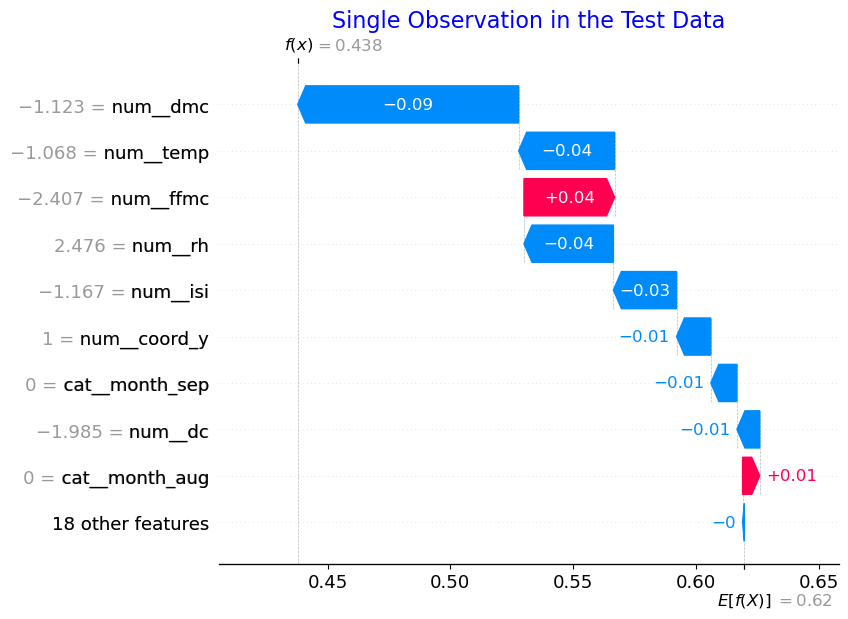

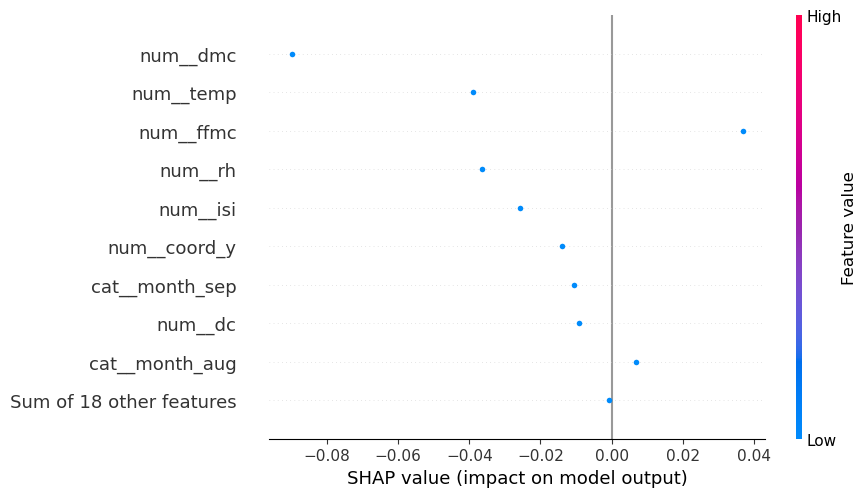

--------------------------------------------------------------------------------


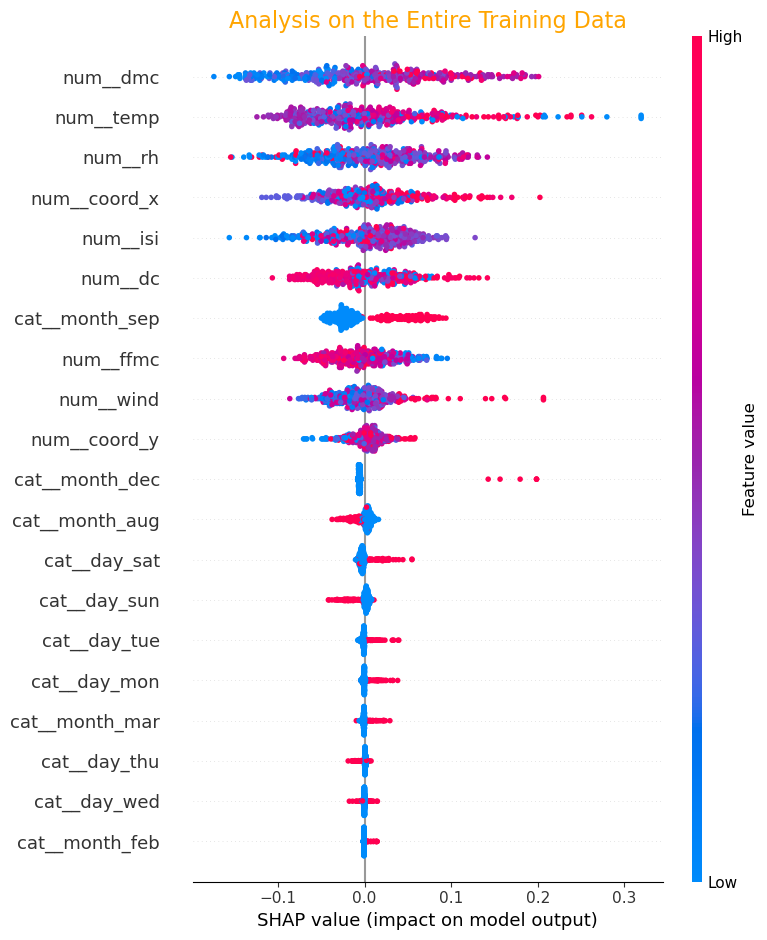

In [20]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1. Get the best pipeline from grid_search_D
best_pipeline = grid_search_A.best_estimator_
# Extract the trained regressor from the best pipeline
model = best_pipeline.named_steps['regressor']
data ={
    'X_test': X_test,
    'X_train': X_train
}
for name, data in data.items():
    # 2. Transform X_test and X_train
    # Note: the high precision (8, in this dataset) will cause SHAP explainer to fail
    # The solution is to round the data_transform with a lower precision for the train data 
    # or, disable check_additivity
    data_transform = best_pipeline.named_steps['preprocessing'].transform(data)
    additivity = False
    observation_idx = 0 

    # 3. Initialize SHAP explainer
    explainer = shap.TreeExplainer(
        model, 
        data_transform,
        feature_names = best_pipeline.named_steps['preprocessing'].get_feature_names_out(),
    )

    # 4. Calculate SHAP values
    if name == 'X_test':
        shap_values = explainer(data_transform[observation_idx:observation_idx+1], check_additivity= additivity)
        # 5. Visualize SHAP values for the selected observation
        plt.figure(figsize=(8,6))
        plt.title("Single Observation in the Test Data", fontsize=16, color='blue')
        shap.initjs()
        
        # Create waterfall plot
        shap.plots.waterfall(shap_values[0])
        
        # Create beeswarm plot
        shap.plots.beeswarm(shap_values)
       
        plt.tight_layout()

        print('--------------------------------------------------------------------------------')
    else:  
        shap_values = explainer(data_transform, check_additivity= additivity)
        # Visualize SHAP values for the entire X_train 
        plt.title("Analysis on the Entire Training Data", fontsize=16, color='orange')
        shap.summary_plot(shap_values, features=data_transform, feature_names=best_pipeline.named_steps['preprocessing'].get_feature_names_out())



- Q1 Explanation on one single observation in X_test:
    - As evident from the results, 9 features such as **_rh, _dmc, _temp, _wind, _isi** exert a substantial influence on prediction outcomes and serve as pivotal factors in the model's forecasts. Specifically, dmc, isi, temp, and location are critical in predicting fire incidents, playing a crucial role in assessing fire risks and determining outcomes.

- Q2 Explanation on the entire X_train:
    - In training tests, the top-ranking features are **_temp, _dmc, _dc, _coord_x, _isi, _rh**. The discrepancies in feature importance calculations between X_train and X_test using SHAP, have several reasons:

    - **Data Distribution Variations**: X_train and X_test may exhibit different distribution characteristics, particularly in handling feature boundaries or outliers, which can affect SHAP value computations.

    - **Sample Selection**: Differences in sample composition between X_train and X_test, especially in small datasets or with different sampling methods, may lead to inconsistent evaluations of feature importance.

    - **Model Training Effects**: Variances in model training and performance between X_train and X_test, particularly in complex models or with imbalanced data, can result in varying assessments of feature importance.

- Q3 **Feature Selection**:
    - Based on the analysis from Q1 and Q2, it is recommended to retain features that exhibit significant influence in both X_test and X_train datasets, particularly those relevant to assessing fire risk and prediction, such as temperature, humidity, geographical coordinates, ffmc index. Also, it is essential to incorporate **domain knowledge** when selecting these feaures. 
        - The following features are recommended for pipeline_A: 
            - _rh,
            - _dmc,
            - _temp,
            - _dc,
            - _isi,
            - _coord_x.
        
    - After testing the selected features in the below code, it suggests that using only a subset of features achieved the same MSE, MAE, and MAD metrics as using all features. This indicates that the previous model was overfitted and more complex. This highlights the power of feature selection.

| Pipeline                        | RMSE (Best) | MAE (Best) | R² (Best)     | MAD      |
|---------------------------------|-------------|------------|---------------|----------|
| Pipeline A (Selected Features)  | 0.4423868   | 0.588388   | -0.0397       | 0.392    |

    
- To evaluate and compare, choose below features for pipeline_C and compare these 2 best pipelines in the REC (Regression Error Curve):
    - wind,
    - rain,
    - temp,
    - rh.
    
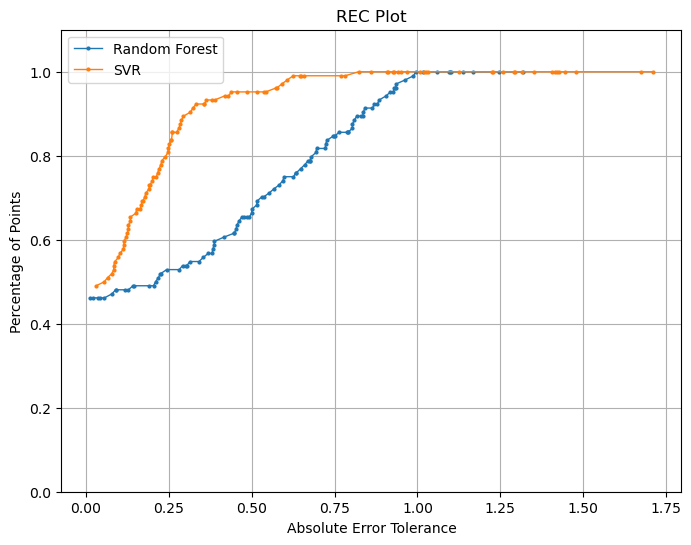  

- If more advanced models, such as neural networks, are included for comparison and negative MSE(former) and negative MAE(later) are used as refit metrics for grid search, we can achieve similar results.

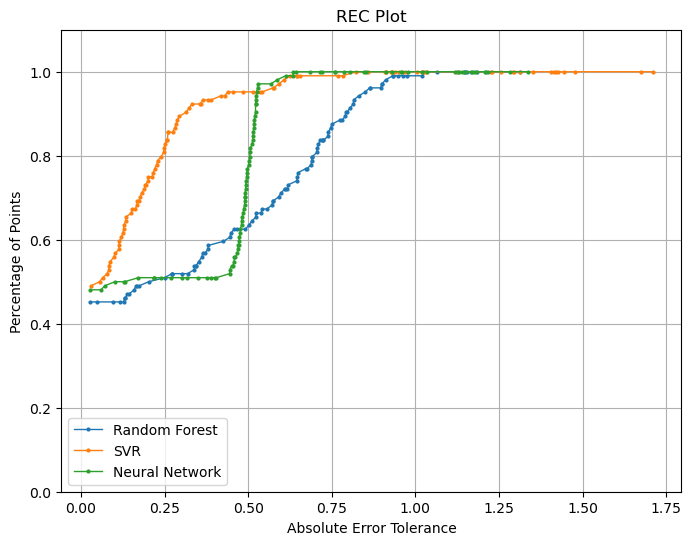 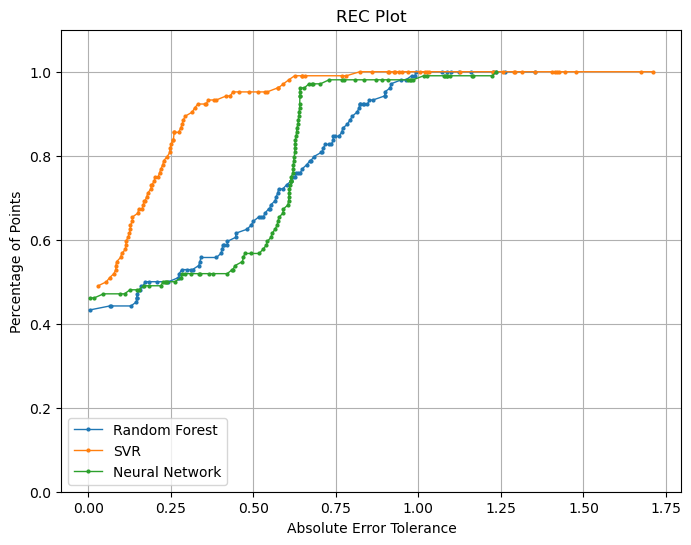

- The SVR curve is closer to the top left corner, indicating it is **more accurate** than the Random Forest and even neural networks at given absolute error tolerances.

**Conclusion**：Using just MAE, RMSE, and MAD isn't enough to fully assess model performance. These metrics focus on prediction errors and may not capture the model's ability to explain variable changes and data structure. When paired with **feature selection**, utilizing diverse metrics and plots is essential for a comprehensive evaluation.

In [45]:
# 0. Testing the features selected from Q3
# Note: The best-performing pipeline may need to be revised due to changes in the features.
from sklearn.neural_network import MLPRegressor
def model_performance(selected_features, preproc_number, param_grid, train= True, prints=False, ranges =1):
    # 1. Define/Transform train data and rest data
    X_train_selected =X_train[selected_features]
    X_test_selected = X_test[selected_features]
    y_train_transformed, _ = boxcox(y_train + 1)
    y_test_transformed, _ = boxcox(y_test + 1)
    scaled_features_selected = list(set(selected_features) & set(numeric_features))
    non_binary_categorical_features_selected = list(set(selected_features) & set(non_binary_categorical_features))

    # 2. Build the Pipeline 
    # Adjust the pipeline's preprocessor since it now selects only a subset of features from X_train, 
    # rendering previous preproc1 and preproc2 ineffective in this context.
    if preproc_number ==1 :
        preproc4 = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, scaled_features_selected),
                ('cat', categorical_transformer, non_binary_categorical_features_selected)
            ],
            remainder='passthrough'
        )
        pipeline = Pipeline(steps=[
            ('preprocessing', preproc4),
            ('regressor', RandomForestRegressor())
        ])
    else: 
        # to preprocess the original data
        scaled_features_selected = list(set(selected_features) & set(scaled_features))
        nonlinear_features_selected = list(set(selected_features) & set(nonlinear_features))
        non_binary_categorical_features_selected = list(set(selected_features) & set(non_binary_categorical_features))

        preproc3 = ColumnTransformer(
            transformers=[
                ('num_nonlinear_transform', nonlinear_transformer, nonlinear_features_selected),
                ('num_scaling', scaler, scaled_features_selected),
                ('cat', categorical_transformer, non_binary_categorical_features_selected)
            ],
            remainder='passthrough'
        )
        if preproc_number ==2: 
            pipeline = Pipeline(steps=[
                ('preprocessing', preproc3),
                ('regressor', SVR())
            ])
        else:
            pipeline = Pipeline(steps=[
                ('preprocessing', preproc3),
                ('regressor', MLPRegressor(max_iter=1000))
            ])

    # 3. Define the scoring metrics for regression
    scoring = [
        'neg_mean_squared_error', 
        'neg_mean_absolute_error', 
        'explained_variance', 
        'r2'
    ]

    # 4. Perform GridSearchCV with cv=5 for 30 times
    mads =[]
    mean_mse_values = []
    mean_mae_values = []
    mean_r2_values = []

    for _ in range(ranges):
        grid_search = GridSearchCV(
            pipeline, 
            param_grid, 
            cv=5, 
            scoring=scoring,
            refit='neg_mean_absolute_error'  # Refit based on neg_mean_squared_error for best model selection
        )
        grid_search.fit(X_train_selected, y_train_transformed)
        y_pred = grid_search.predict(X_train_selected)
        absolute_errors = np.abs(y_train_transformed - y_pred)
        mad = np.mean(absolute_errors)
        mads.append(mad)
        # Extract mean values from cv_results_
        cv_results = grid_search.cv_results_
        mean_mse = np.mean(cv_results['mean_test_neg_mean_squared_error'])
        mean_mae = np.mean(cv_results['mean_test_neg_mean_absolute_error'])
        mean_r2 = np.mean(cv_results['mean_test_r2'])
        # Append to lists
        mean_mse_values.append(mean_mse)
        mean_mae_values.append(mean_mae)
        mean_r2_values.append(mean_r2)
        # print(mad, mean_r2)

    # 5. Calculate overall means
    mean_mad = np.mean(mads)
    mean_mean_mse = np.mean(mean_mse_values)
    mean_mean_mae = np.mean(mean_mae_values)
    mean_mean_r2 = np.mean(mean_r2_values)

    # 6. Display the results
    if prints:
        print(f"Mean MAD: {mean_mad}")
        print(f"Mean Mean Squared Error (MSE): {mean_mean_mse}")
        print(f"Mean Mean Absolute Error (MAE): {mean_mean_mae}")
        print(f"Mean R² Score: {mean_mean_r2}") 

    return grid_search, X_test_selected, y_test_transformed, X_train_selected, y_train_transformed

In [22]:
# Testing the features selected for the best model from Q3 using cross validations
# Grid_search with cv=5 for 30 times
selected_features =['temp','rh','dmc','dc','isi','coord_x']
preproc_number=1
param_grid = {'regressor__bootstrap': [True],
 'regressor__max_depth': [30],
 'regressor__min_samples_leaf': [4],
 'regressor__min_samples_split': [10],
 'regressor__n_estimators': [50]}
grid_search_1, X_test_selected_1, y_test_performed_1, X_train_selected_1, y_train_transformed_1 = model_performance(selected_features, preproc_number, param_grid, train= True, prints= True, ranges =30)

Mean MAD: 0.39299696500482234
Mean Mean Squared Error (MSE): -0.44136640267294325
Mean Mean Absolute Error (MAE): -0.5878883687650981
Mean R² Score: -0.03740052386792813


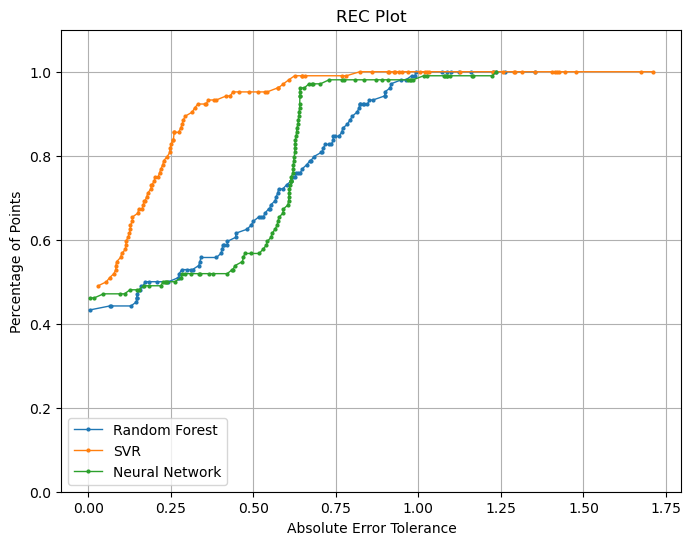

In [46]:
# Plot REC Curve for pipeline evaluation
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# 1. Calculate absolute errors
def calculate_abs_errors(grid_search, X_selected, y_true):
    # 1. Calculate absolute errors
    y_pred = grid_search.predict(X_selected)
    abs_errors = np.abs(y_pred - y_true)
    return abs_errors, y_pred
# 2. Calculate data from REC curve
def calculate_rec(abs_errors, y_true, y_pred):
    m = len(abs_errors)
    abs_errors_sorted = np.sort(abs_errors)  
    total_points = np.arange(1, m + 1)
    rec_data = []

    for tolerance in abs_errors_sorted:
        
        correct = np.sum(y_pred <= y_true + tolerance)
        accuracy = correct / m
        rec_data.append((tolerance, accuracy))

    return rec_data

# 3. Plot REC curves for comparison
def plot_rec(rec_data_list, labels):
    plt.figure(figsize=(8, 6))
    
    for rec_data, label in zip(rec_data_list, labels):
        tolerances, accuracies = zip(*rec_data)
        plt.plot(tolerances, accuracies, marker='o', linestyle='-', markersize=2, linewidth=1, label=label)
    
    plt.xlabel('Absolute Error Tolerance')
    plt.ylabel('Percentage of Points')
    plt.title('REC Plot')
    plt.grid(True)
    plt.ylim(0, 1.1)
    plt.legend()
    plt.show()

# 4. Define arguments and call the subfunctions
selected_features =['rain','rh','wind','temp']
preproc_number =2
param_grid = {
    'regressor__C': [1.0],
    'regressor__coef0': [0.0],
    'regressor__degree': [2],
    'regressor__epsilon': [0.3],
    'regressor__gamma': ['auto'],
    'regressor__kernel': ['rbf'],
    'regressor__shrinking': [True],
    'regressor__tol': [0.001]
}

grid_search_2, X_test_selected_2, y_test_performed_2, X_train_selected_2, y_train_transformed_2 = model_performance(selected_features, preproc_number, param_grid, train= False)
abs_errors, y_pred_test = calculate_abs_errors(grid_search_2, X_test_selected_2, y_test_performed_2)
rec_data_2 = calculate_rec(abs_errors, y_test_performed_2, y_pred_test)

selected_features =['temp','rh','dmc','dc','isi','coord_x']
preproc_number=1
param_grid = {'regressor__bootstrap': [True],
 'regressor__max_depth': [30],
 'regressor__min_samples_leaf': [4],
 'regressor__min_samples_split': [10],
 'regressor__n_estimators': [50]}
grid_search_1, X_test_selected_1, y_test_performed_1, _, _ = model_performance(selected_features, preproc_number, param_grid, train= False)
abs_errors, y_pred_test = calculate_abs_errors(grid_search_1, X_test_selected_1, y_test_performed_1)
rec_data_1 = calculate_rec(abs_errors, y_test_performed_1, y_pred_test)

selected_features =['temp','rh','ffmc','dc','rain','isi']
preproc_number =3
param_grid = {
    'regressor__hidden_layer_sizes': [(64, 32), (128, 64), (256, 128)],
    'regressor__alpha': [1e-4, 1e-3, 1e-2],
    'regressor__activation': ['relu', 'tanh'],
    'regressor__learning_rate_init': [0.001, 0.01],
    'regressor__batch_size': [32, 64],
    'regressor__solver': ['adam']  # 'adam' is typically used for regression tasks
}

grid_search_3, X_test_selected_3, y_test_performed_3, _, _ = model_performance(selected_features, preproc_number, param_grid, train= False)
abs_errors, y_pred_test = calculate_abs_errors(grid_search_3, X_test_selected_3, y_test_performed_3)
rec_data_3 = calculate_rec(abs_errors, y_test_performed_3, y_pred_test)


# plot_rec(rec_data)
rec_data_list = [rec_data_1, rec_data_2, rec_data_3]
labels = ['Random Forest', 'SVR', 'Neural Network']
plot_rec(rec_data_list, labels)    

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.